# I-129 Release/Transport from the Repository

### This notebook computes I-129 release from the repository and transport in the geosphere

In [33]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as tk 
import numpy as np

# Functions for Canister/Inventory Parameters

In [34]:
def get_canister_param(reactor):
    """
    Define the parameters of the canister for each reactor, 
    based on the number of fuel elements obtained in the repository footprint calculation, 
    corresponding to the minimum repository footprint. 
    Return a dictionnary with the HM_loading per fuel unit, the number of fuel unit and the number of canister in the reference repository
    """
    ## ---- Parameters:
    # reactor (str) - reactor name
    ## ---- Returns:
    # canister (dic) - {HM_loading per fuel unit, #fuel unit}
    
    canister={}
    if (reactor=='Ref_PWR'):
        canister={'HM_loading_per_unit': 460000, '# fuel units': 1}
    elif (reactor=='SPWR'):
        canister={'HM_loading_per_unit': 460000, '# fuel units': 4}
    elif (reactor=='HTGR'):
        canister={'HM_loading_per_unit': 8600, '# fuel units': 42}
    elif (reactor=='HPR'):
        canister={'HM_loading_per_unit': 8600, '# fuel units': 42}
    elif (reactor=='HTGR_FCM'):
        canister = {'HM_loading_per_unit': 21200, '# fuel units': 18}
    elif (reactor=='SFR'):
        canister={'HM_loading_per_unit': 98450, '# fuel units': 3}
    else:
        print('missing reactor type')
    return canister 

In [35]:
def get_matrix_param(reactor):
    """
    Define the characteristic of the waste matrix for each reactor
    Return a dictionary with the name of the matrix, the mass of matrix per fuel unit, the low and high degradation rate, and the matrix density
    """
    ## ---- Parameters:
    # reactor (str) - reactor name
    ## ---- Returns:
    # matrix (dic) - {waste form name, mass per fuel unit, low/high degradation rate, density, instant release fraction}
    
    matrix = {}
    if ('PWR' in reactor):
        matrix = {'name': 'UO2',     'mass per fuel unit': 521848.7395, 'low degradation rate': 2.2e-03, 'high degradation rate': 1.1e-02, 'density': 10.5, 'IRF': 0.025}
    elif (reactor=='SPWR'):
        matrix = {'name': 'UO2',     'mass per fuel unit': 521848.7395, 'low degradation rate': 2.2e-03, 'high degradation rate': 1.1e-02, 'density': 10.5, 'IRF': 0.025}
    elif ('HTGR' in reactor):
        matrix = {'name': 'Graphite','mass per fuel unit': 117849.9979, 'low degradation rate': 7.4e-08, 'high degradation rate': 1.3e-06, 'density':1.85, 'IRF': 2.0e-4}
    elif (reactor=='HPR'):
        matrix = {'name': 'Graphite','mass per fuel unit': 117849.9979, 'low degradation rate': 7.4e-08, 'high degradation rate': 1.3e-06, 'density': 1.85, 'IRF': 2.0e-4}
    elif (reactor=='HTGR_FCM'):
        matrix = {'name': 'Graphite','mass per fuel unit': 95492.24603, 'low degradation rate': 7.4e-08, 'high degradation rate': 1.3e-06, 'density': 1.85, 'IRF': 2.0e-4}
    elif (reactor=='SFR'):
        matrix = {'name': 'Metallic','mass per fuel unit': 109388.8889, 'low degradation rate': 1.57,    'high degradation rate': 3.46,    'density':15.8, 'IRF': 0.025}
    else: 
        print('missing reactor type')    
    return matrix 

In [36]:
def scaleGWey2YM(reactors, Npkg):
    """
    Scaleing factor to scale the per-1GWe.y results to the YM repository of 70,000 MTHM
    """
    ## ---- Parameters: 
    #  reactor(str. array) - reactor names
    #  Npkg - # packages per GWe.yr
    ## ---- Returns: 
    #  df - scaling from GWe.yr to YM (70,000MTHW)

    df = pd.DataFrame(columns=['factor'])
    ct = 0;
    for reactor in reactors:
        canister = get_canister_param(reactor)
        canister_loading = canister['HM_loading_per_unit']*canister['# fuel units'] # mass of heavy metal in the canister
        Npkg4YM = 70000e6/canister_loading
        df.loc[reactor,'factor']= Npkg4YM/Npkg[ct]
        ct = ct+1
    return df

# Functions for I129 Release and Transport 

## I-129 Inventory Calculation
This section extracts the concentration of I129 in the spent fuel from the "cooling_reactor.csv" files. With the parameters of the canister, it is possible to calculate the quantity of I129 in each canister.

In [37]:
def get_reactor_results(reactors):
    '''
    Load the cooling dataframe results from OpenMC simulation
    '''
    ## ---- Parameters:
    # reactor (str) - reactor name
    ## ---- Returns:
    # results - SNF metrics from OpenMC

    results=[]
    for i in reactors:
        result=pd.read_csv('./Results/'+i+'/cooling'+i+'.csv', sep=',') # path to post treatment results
        results.append(result)
    return results

In [38]:
def get_I129_canister(reactor, canister, result):
    '''
    Return the molar mass of I129 in the reactor specific canister (mol/canister)
    '''
    ## ---- Parameters:
    # reactor (str) - reactor name
    # canister (dic) - {HM_loading per fuel unit, #fuel unit}
    # results - SNF metrics from OpenMC
    ## ---- Returns:
    # I129_mass - I-129 mass per canister
    
    # I129 parameters 
    half_life  = 15.7*365*24*60*60*(10**6) # in seconds
    Na         = 6.022*(10**23) # Avogadro
    molar_mass = 129 #g/mol
    
    canister_loading = canister['HM_loading_per_unit']*canister['# fuel units'] # mass of heavy metal in the canister
    I129_prop        = result['I129 (atom/cm3)'][0]/Na*result['volume_Ueq'][0]/result['mass U'][0]
    
    I129_mass        = I129_prop*canister_loading # mass if I129 per canister
    return I129_mass

## Fuel matrix dissolution

The degradation rate of the matrix in the environment will depend on the characteristics of the matrix. In this study, it is supposed that the degradation rate of the matrix is constant. The matrix contained in one canister is modelled by a sphere of equivalent mass: this geometrical trasnformation enables to easily consider the evolution of the matrix mass and volume during the degradation process. The radius of the sphere is given by:

$r_{0}=\frac{3M}{4\rho\pi}^{1/3}$

Then, considering a constant degradation rate of the matrix in the environment, the evolution of the radius with time is given as: $ r(t)=r_{0} - R*t$ with $R$ the degradation rate of the matrix. Then, the fraction of the matrix remaining in the canister is simply obtained with: $ f(t)= (1-\frac {Rt}{r_{0}\rho})^3 $

In [39]:
def get_eq_radius(reactor,matrix,tot_mass):
    """
    Calculate the equivalent radius of the canister before canister failure 
    """
    ## ---- Parameters:
    # reactor (str) - reactor name
    # matrix (dic) - {HM_loading per fuel unit, #fuel unit}
    # tot_mass - SNF total mass
    ## ---- Returns:
    # radius - equivalent radius of the canister before canister failure    
    
    density  = matrix['density'] # density of the matrix
    radius   = (3*tot_mass/(4*np.pi*density))**(1/3) # equivalent radius for a matrix sphere with the same mass
    return radius

In [40]:
def get_matrix_remaining(reactor, canister, level, t):
    """
    Calculate the fraction of the matrix remaining in the canister at time t in years
    - level:'high' or 'low' degradation rate
    -     """
    ## ---- Parameters:
    # reactor (str) - reactor name
    # level - 'high' or 'low' degradation rate
    # t - time (list) of interest after canister failure, can be a float or a list of float
    # canister (dic) - {HM_loading per fuel unit, #fuel unit}
    ## ---- Returns:
    # fraction - fraction of the matrix remaining in the canister at time t in years   
   
    # Canister and matrix parameters
    matrix   = get_matrix_param(reactor)
    tot_mass = matrix['mass per fuel unit']*canister['# fuel units']
 
    radius   = get_eq_radius(reactor,matrix,tot_mass)
    degradation_rate =matrix[level+' degradation rate']
    density  = matrix['density']
    
    fraction=(1-degradation_rate/(density*radius)*(10**-4)*t*365)**3
    fraction[fraction < 0] = 0
    return fraction

In [41]:
def df_matrix_remaining(reactors, level, t):
    """
    Create a dataframe with the fraction of the matrix remaining in the waste package
    """
    ## ---- Parameters:
    # reactor (str) - reactor name
    # level - 'high' or 'low' degradation rate
    # t - time (list) of interest after canister failure, can be a float or a list of float
    ## ---- Returns:
    # df - dataframe for the fraction of the matrix remaining in the canister at time t in years   

    df=pd.DataFrame()
    for i in range (len(reactors)):
        reactor  = reactors[i]
        canister = get_canister_param(reactor)
        f_matrix = get_matrix_remaining(reactor, canister,level, t)
        df[reactor] = f_matrix
    df.index = t
    return df

## I129 release from a canister

The conservative behaviour of I129 in the environment enables to make several hypothesis:
- The concentration of I129 in the spent fuel is constant (no decay)
- I129 is released instantly at canister failure $(2,5%)$ and the rest is released congruently to the waste matrix, at the same rate.

Therefore, the total I129 released in the environment after $t$ is given as: $M_{I129}(t)=M_{I129}(0)(IRF+(1-IRF)(1-(1-\frac {Rt}{r_{0}\rho})^3))$

In [42]:
def get_I129_release_can(reactor, result, canister, level, t):
    """
    Calculate the total quantity of I129 (in mol) released in the environment at time t in years for one canister
    """
    ## ---- Parameters:
    # reactor (str) - reactor name
    # level - 'high' or 'low' degradation rate
    # t - time (list) of interest after canister failure, can be a float or a list of float
    # results - SNF metrics from OpenMC
    # canister (dic) - {HM_loading per fuel unit, #fuel unit}
    ## ---- Returns:
    # I129_release - I129 (in mol) released in the environment at time t in years for one canister   

    # I129 inventory in 1 canister in mol
    I129_can = get_I129_canister(reactor, canister, result) 
    
    # fraction of the matrix remaining in the waste package
    matrix_f = get_matrix_remaining(reactor, canister, level, t) 
    IRF      = get_matrix_param(reactor)['IRF']
    
    I129_release = I129_can*(IRF+(1-IRF)*(1-matrix_f))
    return I129_release

In [43]:
def df_I129_release_can(reactors, level, time):
    """
    Create a dataframe with the values of I129 released in the environment for one canister at different time
    """
    df=pd.DataFrame()
    results = get_reactor_results(reactors)
    for i in range (len(reactors)):
        reactor  = reactors[i]
        result   = results[i]
        canister = get_canister_param(reactor)
        
        release     = get_I129_release_can(reactor, result, canister,level, time)
        df[reactor] = release
    df.index        = time
    return df

# PFLOTRAN I/O for transport
This part calculates the total quantity of I129 released in the environment with the paramaters with the same methodoly as presented above from the study P.E Mariner, Application of generic Disposal System Models, 2015. 

In [44]:
def I129_release_rate4PFLOTRAN(I129_release):
    for reactor in I129_release.columns:
        """ 
        Creates a time-varying concentration in a flux at the source term location 
        """
        time = I129_release.index
        
        r = I129_release[reactor]
        t = np.diff(time)
        r = np.diff(r)

        time = time[1:]
        rate = r/t
        time = time[::2]
        rate = rate[::2]
        cons = rate/1e-6

        with open('PFLOTRAN/pflotran_'+reactor+'/CONSTRAINT_reactor.txt','w') as file:
            for i in range(len(time)):
                file.write('CONSTRAINT cons'+str(i)+'\n')
                file.write('  CONCENTRATIONS \n')
                file.write('    I129   {cons:.2e}   T\n'.format(cons = cons[i]))
                file.write('  /\n')
                file.write('END\n')
        file.close()
    
        with open('PFLOTRAN/CONSTRAINT_LIST.txt','w') as file:
            file.write('0.d0 initial \n')
            for i in range(len(time)):
                file.write('{time:.2e}'.format(time=time[i])+'  cons'+str(i)+'\n')
        file.close()

In [45]:
def df_I129_PFLOTRAN2cons(reactors):
    """
    Reads the PFLOTRAN output file at the well loation
    """
    
    half_life  = 15.7*365*24*60*60*(10**6) # in seconds
    lam = np.log(2)/half_life
    
    df=pd.DataFrame()
    for reactor in reactors:
        result=pd.read_csv('PFLOTRAN/pflotran_'+reactor+'/pflotran-obs-0.pft',delimiter=r"\s+",header = 1, names = ["Time [y]","Liquid Pressure [Pa] well (750) (1.4990E+04 10. 0.5)","Liquid Saturation well (750) (1.4990E+04 10. 0.5)","Free I129 [M] well (750) (1.4990E+04 10. 0.5)","Liquid Pressure [Pa] well (751) (1.5010E+04 10. 0.5)","Liquid Saturation well (751) (1.5010E+04 10. 0.5)","Free I129 [M] well (751) (1.5010E+04 10. 0.5)","Liquid Pressure [Pa] well (1750) (1.4990E+04 10. 1.5)","Liquid Saturation well (1750) (1.4990E+04 10. 1.5)","Free I129 [M] well (1750) (1.4990E+04 10. 1.5)","Liquid Pressure [Pa] well (1751) (1.5010E+04 10. 1.5)","Liquid Saturation well (1751) (1.5010E+04 10. 1.5)","Free I129 [M] well (1751) (1.5010E+04 10. 1.5)","Liquid Pressure [Pa] well (2750) (1.4990E+04 10. 2.5)","Liquid Saturation well (2750) (1.4990E+04 10. 2.5)","Free I129 [M] well (2750) (1.4990E+04 10. 2.5)","Liquid Pressure [Pa] well (2751) (1.5010E+04 10. 2.5)","Liquid Saturation well (2751) (1.5010E+04 10. 2.5)","Free I129 [M] well (2751) (1.5010E+04 10. 2.5)","Liquid Pressure [Pa] well (3750) (1.4990E+04 10. 3.5)","Liquid Saturation well (3750) (1.4990E+04 10. 3.5)","Free I129 [M] well (3750) (1.4990E+04 10. 3.5)","Liquid Pressure [Pa] well (3751) (1.5010E+04 10. 3.5)","Liquid Saturation well (3751) (1.5010E+04 10. 3.5)","Free I129 [M] well (3751) (1.5010E+04 10. 3.5)","Liquid Pressure [Pa] well (4750) (1.4990E+04 10. 4.5)","Liquid Saturation well (4750) (1.4990E+04 10. 4.5)","Free I129 [M] well (4750) (1.4990E+04 10. 4.5)","Liquid Pressure [Pa] well (4751) (1.5010E+04 10. 4.5)","Liquid Saturation well (4751) (1.5010E+04 10. 4.5)","Free I129 [M] well (4751) (1.5010E+04 10. 4.5)","Liquid Pressure [Pa] well (5750) (1.4990E+04 10. 5.5)","Liquid Saturation well (5750) (1.4990E+04 10. 5.5)","Free I129 [M] well (5750) (1.4990E+04 10. 5.5)","Liquid Pressure [Pa] well (5751) (1.5010E+04 10. 5.5)","Liquid Saturation well (5751) (1.5010E+04 10. 5.5)","Free I129 [M] well (5751) (1.5010E+04 10. 5.5)","Liquid Pressure [Pa] well (6750) (1.4990E+04 10. 6.5)","Liquid Saturation well (6750) (1.4990E+04 10. 6.5)","Free I129 [M] well (6750) (1.4990E+04 10. 6.5)","Liquid Pressure [Pa] well (6751) (1.5010E+04 10. 6.5)","Liquid Saturation well (6751) (1.5010E+04 10. 6.5)","Free I129 [M] well (6751) (1.5010E+04 10. 6.5)","Liquid Pressure [Pa] well (7750) (1.4990E+04 10. 7.5)","Liquid Saturation well (7750) (1.4990E+04 10. 7.5)","Free I129 [M] well (7750) (1.4990E+04 10. 7.5)","Liquid Pressure [Pa] well (7751) (1.5010E+04 10. 7.5)","Liquid Saturation well (7751) (1.5010E+04 10. 7.5)","Free I129 [M] well (7751) (1.5010E+04 10. 7.5)","Liquid Pressure [Pa] well (8750) (1.4990E+04 10. 8.5)","Liquid Saturation well (8750) (1.4990E+04 10. 8.5)","Free I129 [M] well (8750) (1.4990E+04 10. 8.5)","Liquid Pressure [Pa] well (8751) (1.5010E+04 10. 8.5)","Liquid Saturation well (8751) (1.5010E+04 10. 8.5)","Free I129 [M] well (8751) (1.5010E+04 10. 8.5)","Liquid Pressure [Pa] well (9750) (1.4990E+04 10. 9.5)","Liquid Saturation well (9750) (1.4990E+04 10. 9.5)","Free I129 [M] well (9750) (1.4990E+04 10. 9.5)","Liquid Pressure [Pa] well (9751) (1.5010E+04 10. 9.5)","Liquid Saturation well (9751) (1.5010E+04 10. 9.5)","Free I129 [M] well (9751) (1.5010E+04 10. 9.5)","Liquid Pressure [Pa] well (10750) (1.4990E+04 10. 10.5)","Liquid Saturation well (10750) (1.4990E+04 10. 10.5)","Free I129 [M] well (10750) (1.4990E+04 10. 10.5)","Liquid Pressure [Pa] well (10751) (1.5010E+04 10. 10.5)","Liquid Saturation well (10751) (1.5010E+04 10. 10.5)","Free I129 [M] well (10751) (1.5010E+04 10. 10.5)","Liquid Pressure [Pa] well (11750) (1.4990E+04 10. 11.5)","Liquid Saturation well (11750) (1.4990E+04 10. 11.5)","Free I129 [M] well (11750) (1.4990E+04 10. 11.5)","Liquid Pressure [Pa] well (11751) (1.5010E+04 10. 11.5)","Liquid Saturation well (11751) (1.5010E+04 10. 11.5)","Free I129 [M] well (11751) (1.5010E+04 10. 11.5)","Liquid Pressure [Pa] well (12750) (1.4990E+04 10. 12.5)","Liquid Saturation well (12750) (1.4990E+04 10. 12.5)","Free I129 [M] well (12750) (1.4990E+04 10. 12.5)","Liquid Pressure [Pa] well (12751) (1.5010E+04 10. 12.5)","Liquid Saturation well (12751) (1.5010E+04 10. 12.5)","Free I129 [M] well (12751) (1.5010E+04 10. 12.5)","Liquid Pressure [Pa] well (13750) (1.4990E+04 10. 13.5)","Liquid Saturation well (13750) (1.4990E+04 10. 13.5)","Free I129 [M] well (13750) (1.4990E+04 10. 13.5)","Liquid Pressure [Pa] well (13751) (1.5010E+04 10. 13.5)","Liquid Saturation well (13751) (1.5010E+04 10. 13.5)","Free I129 [M] well (13751) (1.5010E+04 10. 13.5)","Liquid Pressure [Pa] well (14750) (1.4990E+04 10. 14.5)","Liquid Saturation well (14750) (1.4990E+04 10. 14.5)","Free I129 [M] well (14750) (1.4990E+04 10. 14.5)","Liquid Pressure [Pa] well (14751) (1.5010E+04 10. 14.5)","Liquid Saturation well (14751) (1.5010E+04 10. 14.5)","Free I129 [M] well (14751) (1.5010E+04 10. 14.5)","Liquid Pressure [Pa] well (15750) (1.4990E+04 10. 15.5)","Liquid Saturation well (15750) (1.4990E+04 10. 15.5)","Free I129 [M] well (15750) (1.4990E+04 10. 15.5)","Liquid Pressure [Pa] well (15751) (1.5010E+04 10. 15.5)","Liquid Saturation well (15751) (1.5010E+04 10. 15.5)","Free I129 [M] well (15751) (1.5010E+04 10. 15.5)","Liquid Pressure [Pa] well (16750) (1.4990E+04 10. 16.5)","Liquid Saturation well (16750) (1.4990E+04 10. 16.5)","Free I129 [M] well (16750) (1.4990E+04 10. 16.5)","Liquid Pressure [Pa] well (16751) (1.5010E+04 10. 16.5)","Liquid Saturation well (16751) (1.5010E+04 10. 16.5)","Free I129 [M] well (16751) (1.5010E+04 10. 16.5)","Liquid Pressure [Pa] well (17750) (1.4990E+04 10. 17.5)","Liquid Saturation well (17750) (1.4990E+04 10. 17.5)","Free I129 [M] well (17750) (1.4990E+04 10. 17.5)","Liquid Pressure [Pa] well (17751) (1.5010E+04 10. 17.5)","Liquid Saturation well (17751) (1.5010E+04 10. 17.5)","Free I129 [M] well (17751) (1.5010E+04 10. 17.5)","Liquid Pressure [Pa] well (18750) (1.4990E+04 10. 18.5)","Liquid Saturation well (18750) (1.4990E+04 10. 18.5)","Free I129 [M] well (18750) (1.4990E+04 10. 18.5)","Liquid Pressure [Pa] well (18751) (1.5010E+04 10. 18.5)","Liquid Saturation well (18751) (1.5010E+04 10. 18.5)","Free I129 [M] well (18751) (1.5010E+04 10. 18.5)","Liquid Pressure [Pa] well (19750) (1.4990E+04 10. 19.5)","Liquid Saturation well (19750) (1.4990E+04 10. 19.5)","Free I129 [M] well (19750) (1.4990E+04 10. 19.5)","Liquid Pressure [Pa] well (19751) (1.5010E+04 10. 19.5)","Liquid Saturation well (19751) (1.5010E+04 10. 19.5)","Free I129 [M] well (19751) (1.5010E+04 10. 19.5)","Liquid Pressure [Pa] well (20750) (1.4990E+04 10. 20.5)","Liquid Saturation well (20750) (1.4990E+04 10. 20.5)","Free I129 [M] well (20750) (1.4990E+04 10. 20.5)","Liquid Pressure [Pa] well (20751) (1.5010E+04 10. 20.5)","Liquid Saturation well (20751) (1.5010E+04 10. 20.5)","Free I129 [M] well (20751) (1.5010E+04 10. 20.5)","Liquid Pressure [Pa] well (21750) (1.4990E+04 10. 21.5)","Liquid Saturation well (21750) (1.4990E+04 10. 21.5)","Free I129 [M] well (21750) (1.4990E+04 10. 21.5)","Liquid Pressure [Pa] well (21751) (1.5010E+04 10. 21.5)","Liquid Saturation well (21751) (1.5010E+04 10. 21.5)","Free I129 [M] well (21751) (1.5010E+04 10. 21.5)","Liquid Pressure [Pa] well (22750) (1.4990E+04 10. 22.5)","Liquid Saturation well (22750) (1.4990E+04 10. 22.5)","Free I129 [M] well (22750) (1.4990E+04 10. 22.5)","Liquid Pressure [Pa] well (22751) (1.5010E+04 10. 22.5)","Liquid Saturation well (22751) (1.5010E+04 10. 22.5)","Free I129 [M] well (22751) (1.5010E+04 10. 22.5)","Liquid Pressure [Pa] well (23750) (1.4990E+04 10. 23.5)","Liquid Saturation well (23750) (1.4990E+04 10. 23.5)","Free I129 [M] well (23750) (1.4990E+04 10. 23.5)","Liquid Pressure [Pa] well (23751) (1.5010E+04 10. 23.5)","Liquid Saturation well (23751) (1.5010E+04 10. 23.5)","Free I129 [M] well (23751) (1.5010E+04 10. 23.5)","Liquid Pressure [Pa] well (24750) (1.4990E+04 10. 24.5)","Liquid Saturation well (24750) (1.4990E+04 10. 24.5)","Free I129 [M] well (24750) (1.4990E+04 10. 24.5)","Liquid Pressure [Pa] well (24751) (1.5010E+04 10. 24.5)","Liquid Saturation well (24751) (1.5010E+04 10. 24.5)","Free I129 [M] well (24751) (1.5010E+04 10. 24.5)","Liquid Pressure [Pa] well (25750) (1.4990E+04 10. 25.5)","Liquid Saturation well (25750) (1.4990E+04 10. 25.5)","Free I129 [M] well (25750) (1.4990E+04 10. 25.5)","Liquid Pressure [Pa] well (25751) (1.5010E+04 10. 25.5)","Liquid Saturation well (25751) (1.5010E+04 10. 25.5)","Free I129 [M] well (25751) (1.5010E+04 10. 25.5)","Liquid Pressure [Pa] well (26750) (1.4990E+04 10. 26.5)","Liquid Saturation well (26750) (1.4990E+04 10. 26.5)","Free I129 [M] well (26750) (1.4990E+04 10. 26.5)","Liquid Pressure [Pa] well (26751) (1.5010E+04 10. 26.5)","Liquid Saturation well (26751) (1.5010E+04 10. 26.5)","Free I129 [M] well (26751) (1.5010E+04 10. 26.5)","Liquid Pressure [Pa] well (27750) (1.4990E+04 10. 27.5)","Liquid Saturation well (27750) (1.4990E+04 10. 27.5)","Free I129 [M] well (27750) (1.4990E+04 10. 27.5)","Liquid Pressure [Pa] well (27751) (1.5010E+04 10. 27.5)","Liquid Saturation well (27751) (1.5010E+04 10. 27.5)","Free I129 [M] well (27751) (1.5010E+04 10. 27.5)","Liquid Pressure [Pa] well (28750) (1.4990E+04 10. 28.5)","Liquid Saturation well (28750) (1.4990E+04 10. 28.5)","Free I129 [M] well (28750) (1.4990E+04 10. 28.5)","Liquid Pressure [Pa] well (28751) (1.5010E+04 10. 28.5)","Liquid Saturation well (28751) (1.5010E+04 10. 28.5)","Free I129 [M] well (28751) (1.5010E+04 10. 28.5)","Liquid Pressure [Pa] well (29750) (1.4990E+04 10. 29.5)","Liquid Saturation well (29750) (1.4990E+04 10. 29.5)","Free I129 [M] well (29750) (1.4990E+04 10. 29.5)","Liquid Pressure [Pa] well (29751) (1.5010E+04 10. 29.5)","Liquid Saturation well (29751) (1.5010E+04 10. 29.5)","Free I129 [M] well (29751) (1.5010E+04 10. 29.5)","Liquid Pressure [Pa] well (30750) (1.4990E+04 10. 30.5)","Liquid Saturation well (30750) (1.4990E+04 10. 30.5)","Free I129 [M] well (30750) (1.4990E+04 10. 30.5)","Liquid Pressure [Pa] well (30751) (1.5010E+04 10. 30.5)","Liquid Saturation well (30751) (1.5010E+04 10. 30.5)","Free I129 [M] well (30751) (1.5010E+04 10. 30.5)","Liquid Pressure [Pa] well (31750) (1.4990E+04 10. 31.5)","Liquid Saturation well (31750) (1.4990E+04 10. 31.5)","Free I129 [M] well (31750) (1.4990E+04 10. 31.5)","Liquid Pressure [Pa] well (31751) (1.5010E+04 10. 31.5)","Liquid Saturation well (31751) (1.5010E+04 10. 31.5)","Free I129 [M] well (31751) (1.5010E+04 10. 31.5)","Liquid Pressure [Pa] well (32750) (1.4990E+04 10. 32.5)","Liquid Saturation well (32750) (1.4990E+04 10. 32.5)","Free I129 [M] well (32750) (1.4990E+04 10. 32.5)","Liquid Pressure [Pa] well (32751) (1.5010E+04 10. 32.5)","Liquid Saturation well (32751) (1.5010E+04 10. 32.5)","Free I129 [M] well (32751) (1.5010E+04 10. 32.5)","Liquid Pressure [Pa] well (33750) (1.4990E+04 10. 33.5)","Liquid Saturation well (33750) (1.4990E+04 10. 33.5)","Free I129 [M] well (33750) (1.4990E+04 10. 33.5)","Liquid Pressure [Pa] well (33751) (1.5010E+04 10. 33.5)","Liquid Saturation well (33751) (1.5010E+04 10. 33.5)","Free I129 [M] well (33751) (1.5010E+04 10. 33.5)","Liquid Pressure [Pa] well (34750) (1.4990E+04 10. 34.5)","Liquid Saturation well (34750) (1.4990E+04 10. 34.5)","Free I129 [M] well (34750) (1.4990E+04 10. 34.5)","Liquid Pressure [Pa] well (34751) (1.5010E+04 10. 34.5)","Liquid Saturation well (34751) (1.5010E+04 10. 34.5)","Free I129 [M] well (34751) (1.5010E+04 10. 34.5)","Liquid Pressure [Pa] well (35750) (1.4990E+04 10. 35.5)","Liquid Saturation well (35750) (1.4990E+04 10. 35.5)","Free I129 [M] well (35750) (1.4990E+04 10. 35.5)","Liquid Pressure [Pa] well (35751) (1.5010E+04 10. 35.5)","Liquid Saturation well (35751) (1.5010E+04 10. 35.5)","Free I129 [M] well (35751) (1.5010E+04 10. 35.5)","Liquid Pressure [Pa] well (36750) (1.4990E+04 10. 36.5)","Liquid Saturation well (36750) (1.4990E+04 10. 36.5)","Free I129 [M] well (36750) (1.4990E+04 10. 36.5)","Liquid Pressure [Pa] well (36751) (1.5010E+04 10. 36.5)","Liquid Saturation well (36751) (1.5010E+04 10. 36.5)","Free I129 [M] well (36751) (1.5010E+04 10. 36.5)","Liquid Pressure [Pa] well (37750) (1.4990E+04 10. 37.5)","Liquid Saturation well (37750) (1.4990E+04 10. 37.5)","Free I129 [M] well (37750) (1.4990E+04 10. 37.5)","Liquid Pressure [Pa] well (37751) (1.5010E+04 10. 37.5)","Liquid Saturation well (37751) (1.5010E+04 10. 37.5)","Free I129 [M] well (37751) (1.5010E+04 10. 37.5)","Liquid Pressure [Pa] well (38750) (1.4990E+04 10. 38.5)","Liquid Saturation well (38750) (1.4990E+04 10. 38.5)","Free I129 [M] well (38750) (1.4990E+04 10. 38.5)","Liquid Pressure [Pa] well (38751) (1.5010E+04 10. 38.5)","Liquid Saturation well (38751) (1.5010E+04 10. 38.5)","Free I129 [M] well (38751) (1.5010E+04 10. 38.5)","Liquid Pressure [Pa] well (39750) (1.4990E+04 10. 39.5)","Liquid Saturation well (39750) (1.4990E+04 10. 39.5)","Free I129 [M] well (39750) (1.4990E+04 10. 39.5)","Liquid Pressure [Pa] well (39751) (1.5010E+04 10. 39.5)","Liquid Saturation well (39751) (1.5010E+04 10. 39.5)","Free I129 [M] well (39751) (1.5010E+04 10. 39.5)","Liquid Pressure [Pa] well (40750) (1.4990E+04 10. 40.5)","Liquid Saturation well (40750) (1.4990E+04 10. 40.5)","Free I129 [M] well (40750) (1.4990E+04 10. 40.5)","Liquid Pressure [Pa] well (40751) (1.5010E+04 10. 40.5)","Liquid Saturation well (40751) (1.5010E+04 10. 40.5)","Free I129 [M] well (40751) (1.5010E+04 10. 40.5)","Liquid Pressure [Pa] well (41750) (1.4990E+04 10. 41.5)","Liquid Saturation well (41750) (1.4990E+04 10. 41.5)","Free I129 [M] well (41750) (1.4990E+04 10. 41.5)","Liquid Pressure [Pa] well (41751) (1.5010E+04 10. 41.5)","Liquid Saturation well (41751) (1.5010E+04 10. 41.5)","Free I129 [M] well (41751) (1.5010E+04 10. 41.5)","Liquid Pressure [Pa] well (42750) (1.4990E+04 10. 42.5)","Liquid Saturation well (42750) (1.4990E+04 10. 42.5)","Free I129 [M] well (42750) (1.4990E+04 10. 42.5)","Liquid Pressure [Pa] well (42751) (1.5010E+04 10. 42.5)","Liquid Saturation well (42751) (1.5010E+04 10. 42.5)","Free I129 [M] well (42751) (1.5010E+04 10. 42.5)","Liquid Pressure [Pa] well (43750) (1.4990E+04 10. 43.5)","Liquid Saturation well (43750) (1.4990E+04 10. 43.5)","Free I129 [M] well (43750) (1.4990E+04 10. 43.5)","Liquid Pressure [Pa] well (43751) (1.5010E+04 10. 43.5)","Liquid Saturation well (43751) (1.5010E+04 10. 43.5)","Free I129 [M] well (43751) (1.5010E+04 10. 43.5)","Liquid Pressure [Pa] well (44750) (1.4990E+04 10. 44.5)","Liquid Saturation well (44750) (1.4990E+04 10. 44.5)","Free I129 [M] well (44750) (1.4990E+04 10. 44.5)","Liquid Pressure [Pa] well (44751) (1.5010E+04 10. 44.5)","Liquid Saturation well (44751) (1.5010E+04 10. 44.5)","Free I129 [M] well (44751) (1.5010E+04 10. 44.5)","Liquid Pressure [Pa] well (45750) (1.4990E+04 10. 45.5)","Liquid Saturation well (45750) (1.4990E+04 10. 45.5)","Free I129 [M] well (45750) (1.4990E+04 10. 45.5)","Liquid Pressure [Pa] well (45751) (1.5010E+04 10. 45.5)","Liquid Saturation well (45751) (1.5010E+04 10. 45.5)","Free I129 [M] well (45751) (1.5010E+04 10. 45.5)","Liquid Pressure [Pa] well (46750) (1.4990E+04 10. 46.5)","Liquid Saturation well (46750) (1.4990E+04 10. 46.5)","Free I129 [M] well (46750) (1.4990E+04 10. 46.5)","Liquid Pressure [Pa] well (46751) (1.5010E+04 10. 46.5)","Liquid Saturation well (46751) (1.5010E+04 10. 46.5)","Free I129 [M] well (46751) (1.5010E+04 10. 46.5)","Liquid Pressure [Pa] well (47750) (1.4990E+04 10. 47.5)","Liquid Saturation well (47750) (1.4990E+04 10. 47.5)","Free I129 [M] well (47750) (1.4990E+04 10. 47.5)","Liquid Pressure [Pa] well (47751) (1.5010E+04 10. 47.5)","Liquid Saturation well (47751) (1.5010E+04 10. 47.5)","Free I129 [M] well (47751) (1.5010E+04 10. 47.5)","Liquid Pressure [Pa] well (48750) (1.4990E+04 10. 48.5)","Liquid Saturation well (48750) (1.4990E+04 10. 48.5)","Free I129 [M] well (48750) (1.4990E+04 10. 48.5)","Liquid Pressure [Pa] well (48751) (1.5010E+04 10. 48.5)","Liquid Saturation well (48751) (1.5010E+04 10. 48.5)","Free I129 [M] well (48751) (1.5010E+04 10. 48.5)","Liquid Pressure [Pa] well (49750) (1.4990E+04 10. 49.5)","Liquid Saturation well (49750) (1.4990E+04 10. 49.5)","Free I129 [M] well (49750) (1.4990E+04 10. 49.5)","Liquid Pressure [Pa] well (49751) (1.5010E+04 10. 49.5)","Liquid Saturation well (49751) (1.5010E+04 10. 49.5)","Free I129 [M] well (49751) (1.5010E+04 10. 49.5)","Liquid Pressure [Pa] well (50750) (1.4990E+04 10. 50.5)","Liquid Saturation well (50750) (1.4990E+04 10. 50.5)","Free I129 [M] well (50750) (1.4990E+04 10. 50.5)","Liquid Pressure [Pa] well (50751) (1.5010E+04 10. 50.5)","Liquid Saturation well (50751) (1.5010E+04 10. 50.5)","Free I129 [M] well (50751) (1.5010E+04 10. 50.5)","Liquid Pressure [Pa] well (51750) (1.4990E+04 10. 51.5)","Liquid Saturation well (51750) (1.4990E+04 10. 51.5)","Free I129 [M] well (51750) (1.4990E+04 10. 51.5)","Liquid Pressure [Pa] well (51751) (1.5010E+04 10. 51.5)","Liquid Saturation well (51751) (1.5010E+04 10. 51.5)","Free I129 [M] well (51751) (1.5010E+04 10. 51.5)","Liquid Pressure [Pa] well (52750) (1.4990E+04 10. 52.5)","Liquid Saturation well (52750) (1.4990E+04 10. 52.5)","Free I129 [M] well (52750) (1.4990E+04 10. 52.5)","Liquid Pressure [Pa] well (52751) (1.5010E+04 10. 52.5)","Liquid Saturation well (52751) (1.5010E+04 10. 52.5)","Free I129 [M] well (52751) (1.5010E+04 10. 52.5)","Liquid Pressure [Pa] well (53750) (1.4990E+04 10. 53.5)","Liquid Saturation well (53750) (1.4990E+04 10. 53.5)","Free I129 [M] well (53750) (1.4990E+04 10. 53.5)","Liquid Pressure [Pa] well (53751) (1.5010E+04 10. 53.5)","Liquid Saturation well (53751) (1.5010E+04 10. 53.5)","Free I129 [M] well (53751) (1.5010E+04 10. 53.5)","Liquid Pressure [Pa] well (54750) (1.4990E+04 10. 54.5)","Liquid Saturation well (54750) (1.4990E+04 10. 54.5)","Free I129 [M] well (54750) (1.4990E+04 10. 54.5)","Liquid Pressure [Pa] well (54751) (1.5010E+04 10. 54.5)","Liquid Saturation well (54751) (1.5010E+04 10. 54.5)","Free I129 [M] well (54751) (1.5010E+04 10. 54.5)","Liquid Pressure [Pa] well (55750) (1.4990E+04 10. 55.5)","Liquid Saturation well (55750) (1.4990E+04 10. 55.5)","Free I129 [M] well (55750) (1.4990E+04 10. 55.5)","Liquid Pressure [Pa] well (55751) (1.5010E+04 10. 55.5)","Liquid Saturation well (55751) (1.5010E+04 10. 55.5)","Free I129 [M] well (55751) (1.5010E+04 10. 55.5)","Liquid Pressure [Pa] well (56750) (1.4990E+04 10. 56.5)","Liquid Saturation well (56750) (1.4990E+04 10. 56.5)","Free I129 [M] well (56750) (1.4990E+04 10. 56.5)","Liquid Pressure [Pa] well (56751) (1.5010E+04 10. 56.5)","Liquid Saturation well (56751) (1.5010E+04 10. 56.5)","Free I129 [M] well (56751) (1.5010E+04 10. 56.5)","Liquid Pressure [Pa] well (57750) (1.4990E+04 10. 57.5)","Liquid Saturation well (57750) (1.4990E+04 10. 57.5)","Free I129 [M] well (57750) (1.4990E+04 10. 57.5)","Liquid Pressure [Pa] well (57751) (1.5010E+04 10. 57.5)","Liquid Saturation well (57751) (1.5010E+04 10. 57.5)","Free I129 [M] well (57751) (1.5010E+04 10. 57.5)","Liquid Pressure [Pa] well (58750) (1.4990E+04 10. 58.5)","Liquid Saturation well (58750) (1.4990E+04 10. 58.5)","Free I129 [M] well (58750) (1.4990E+04 10. 58.5)","Liquid Pressure [Pa] well (58751) (1.5010E+04 10. 58.5)","Liquid Saturation well (58751) (1.5010E+04 10. 58.5)","Free I129 [M] well (58751) (1.5010E+04 10. 58.5)","Liquid Pressure [Pa] well (59750) (1.4990E+04 10. 59.5)","Liquid Saturation well (59750) (1.4990E+04 10. 59.5)","Free I129 [M] well (59750) (1.4990E+04 10. 59.5)","Liquid Pressure [Pa] well (59751) (1.5010E+04 10. 59.5)","Liquid Saturation well (59751) (1.5010E+04 10. 59.5)","Free I129 [M] well (59751) (1.5010E+04 10. 59.5)","Liquid Pressure [Pa] well (60750) (1.4990E+04 10. 60.5)","Liquid Saturation well (60750) (1.4990E+04 10. 60.5)","Free I129 [M] well (60750) (1.4990E+04 10. 60.5)","Liquid Pressure [Pa] well (60751) (1.5010E+04 10. 60.5)","Liquid Saturation well (60751) (1.5010E+04 10. 60.5)","Free I129 [M] well (60751) (1.5010E+04 10. 60.5)","Liquid Pressure [Pa] well (61750) (1.4990E+04 10. 61.5)","Liquid Saturation well (61750) (1.4990E+04 10. 61.5)","Free I129 [M] well (61750) (1.4990E+04 10. 61.5)","Liquid Pressure [Pa] well (61751) (1.5010E+04 10. 61.5)","Liquid Saturation well (61751) (1.5010E+04 10. 61.5)","Free I129 [M] well (61751) (1.5010E+04 10. 61.5)","Liquid Pressure [Pa] well (62750) (1.4990E+04 10. 62.5)","Liquid Saturation well (62750) (1.4990E+04 10. 62.5)","Free I129 [M] well (62750) (1.4990E+04 10. 62.5)","Liquid Pressure [Pa] well (62751) (1.5010E+04 10. 62.5)","Liquid Saturation well (62751) (1.5010E+04 10. 62.5)","Free I129 [M] well (62751) (1.5010E+04 10. 62.5)","Liquid Pressure [Pa] well (63750) (1.4990E+04 10. 63.5)","Liquid Saturation well (63750) (1.4990E+04 10. 63.5)","Free I129 [M] well (63750) (1.4990E+04 10. 63.5)","Liquid Pressure [Pa] well (63751) (1.5010E+04 10. 63.5)","Liquid Saturation well (63751) (1.5010E+04 10. 63.5)","Free I129 [M] well (63751) (1.5010E+04 10. 63.5)","Liquid Pressure [Pa] well (64750) (1.4990E+04 10. 64.5)","Liquid Saturation well (64750) (1.4990E+04 10. 64.5)","Free I129 [M] well (64750) (1.4990E+04 10. 64.5)","Liquid Pressure [Pa] well (64751) (1.5010E+04 10. 64.5)","Liquid Saturation well (64751) (1.5010E+04 10. 64.5)","Free I129 [M] well (64751) (1.5010E+04 10. 64.5)","Liquid Pressure [Pa] well (65750) (1.4990E+04 10. 65.5)","Liquid Saturation well (65750) (1.4990E+04 10. 65.5)","Free I129 [M] well (65750) (1.4990E+04 10. 65.5)","Liquid Pressure [Pa] well (65751) (1.5010E+04 10. 65.5)","Liquid Saturation well (65751) (1.5010E+04 10. 65.5)","Free I129 [M] well (65751) (1.5010E+04 10. 65.5)","Liquid Pressure [Pa] well (66750) (1.4990E+04 10. 66.5)","Liquid Saturation well (66750) (1.4990E+04 10. 66.5)","Free I129 [M] well (66750) (1.4990E+04 10. 66.5)","Liquid Pressure [Pa] well (66751) (1.5010E+04 10. 66.5)","Liquid Saturation well (66751) (1.5010E+04 10. 66.5)","Free I129 [M] well (66751) (1.5010E+04 10. 66.5)","Liquid Pressure [Pa] well (67750) (1.4990E+04 10. 67.5)","Liquid Saturation well (67750) (1.4990E+04 10. 67.5)","Free I129 [M] well (67750) (1.4990E+04 10. 67.5)","Liquid Pressure [Pa] well (67751) (1.5010E+04 10. 67.5)","Liquid Saturation well (67751) (1.5010E+04 10. 67.5)","Free I129 [M] well (67751) (1.5010E+04 10. 67.5)","Liquid Pressure [Pa] well (68750) (1.4990E+04 10. 68.5)","Liquid Saturation well (68750) (1.4990E+04 10. 68.5)","Free I129 [M] well (68750) (1.4990E+04 10. 68.5)","Liquid Pressure [Pa] well (68751) (1.5010E+04 10. 68.5)","Liquid Saturation well (68751) (1.5010E+04 10. 68.5)","Free I129 [M] well (68751) (1.5010E+04 10. 68.5)","Liquid Pressure [Pa] well (69750) (1.4990E+04 10. 69.5)","Liquid Saturation well (69750) (1.4990E+04 10. 69.5)","Free I129 [M] well (69750) (1.4990E+04 10. 69.5)","Liquid Pressure [Pa] well (69751) (1.5010E+04 10. 69.5)","Liquid Saturation well (69751) (1.5010E+04 10. 69.5)","Free I129 [M] well (69751) (1.5010E+04 10. 69.5)","Liquid Pressure [Pa] well (70750) (1.4990E+04 10. 70.5)","Liquid Saturation well (70750) (1.4990E+04 10. 70.5)","Free I129 [M] well (70750) (1.4990E+04 10. 70.5)","Liquid Pressure [Pa] well (70751) (1.5010E+04 10. 70.5)","Liquid Saturation well (70751) (1.5010E+04 10. 70.5)","Free I129 [M] well (70751) (1.5010E+04 10. 70.5)","Liquid Pressure [Pa] well (71750) (1.4990E+04 10. 71.5)","Liquid Saturation well (71750) (1.4990E+04 10. 71.5)","Free I129 [M] well (71750) (1.4990E+04 10. 71.5)","Liquid Pressure [Pa] well (71751) (1.5010E+04 10. 71.5)","Liquid Saturation well (71751) (1.5010E+04 10. 71.5)","Free I129 [M] well (71751) (1.5010E+04 10. 71.5)","Liquid Pressure [Pa] well (72750) (1.4990E+04 10. 72.5)","Liquid Saturation well (72750) (1.4990E+04 10. 72.5)","Free I129 [M] well (72750) (1.4990E+04 10. 72.5)","Liquid Pressure [Pa] well (72751) (1.5010E+04 10. 72.5)","Liquid Saturation well (72751) (1.5010E+04 10. 72.5)","Free I129 [M] well (72751) (1.5010E+04 10. 72.5)","Liquid Pressure [Pa] well (73750) (1.4990E+04 10. 73.5)","Liquid Saturation well (73750) (1.4990E+04 10. 73.5)","Free I129 [M] well (73750) (1.4990E+04 10. 73.5)","Liquid Pressure [Pa] well (73751) (1.5010E+04 10. 73.5)","Liquid Saturation well (73751) (1.5010E+04 10. 73.5)","Free I129 [M] well (73751) (1.5010E+04 10. 73.5)","Liquid Pressure [Pa] well (74750) (1.4990E+04 10. 74.5)","Liquid Saturation well (74750) (1.4990E+04 10. 74.5)","Free I129 [M] well (74750) (1.4990E+04 10. 74.5)","Liquid Pressure [Pa] well (74751) (1.5010E+04 10. 74.5)","Liquid Saturation well (74751) (1.5010E+04 10. 74.5)","Free I129 [M] well (74751) (1.5010E+04 10. 74.5)","Liquid Pressure [Pa] well (75750) (1.4990E+04 10. 75.5)","Liquid Saturation well (75750) (1.4990E+04 10. 75.5)","Free I129 [M] well (75750) (1.4990E+04 10. 75.5)","Liquid Pressure [Pa] well (75751) (1.5010E+04 10. 75.5)","Liquid Saturation well (75751) (1.5010E+04 10. 75.5)","Free I129 [M] well (75751) (1.5010E+04 10. 75.5)","Liquid Pressure [Pa] well (76750) (1.4990E+04 10. 76.5)","Liquid Saturation well (76750) (1.4990E+04 10. 76.5)","Free I129 [M] well (76750) (1.4990E+04 10. 76.5)","Liquid Pressure [Pa] well (76751) (1.5010E+04 10. 76.5)","Liquid Saturation well (76751) (1.5010E+04 10. 76.5)","Free I129 [M] well (76751) (1.5010E+04 10. 76.5)","Liquid Pressure [Pa] well (77750) (1.4990E+04 10. 77.5)","Liquid Saturation well (77750) (1.4990E+04 10. 77.5)","Free I129 [M] well (77750) (1.4990E+04 10. 77.5)","Liquid Pressure [Pa] well (77751) (1.5010E+04 10. 77.5)","Liquid Saturation well (77751) (1.5010E+04 10. 77.5)","Free I129 [M] well (77751) (1.5010E+04 10. 77.5)","Liquid Pressure [Pa] well (78750) (1.4990E+04 10. 78.5)","Liquid Saturation well (78750) (1.4990E+04 10. 78.5)","Free I129 [M] well (78750) (1.4990E+04 10. 78.5)","Liquid Pressure [Pa] well (78751) (1.5010E+04 10. 78.5)","Liquid Saturation well (78751) (1.5010E+04 10. 78.5)","Free I129 [M] well (78751) (1.5010E+04 10. 78.5)","Liquid Pressure [Pa] well (79750) (1.4990E+04 10. 79.5)","Liquid Saturation well (79750) (1.4990E+04 10. 79.5)","Free I129 [M] well (79750) (1.4990E+04 10. 79.5)","Liquid Pressure [Pa] well (79751) (1.5010E+04 10. 79.5)","Liquid Saturation well (79751) (1.5010E+04 10. 79.5)","Free I129 [M] well (79751) (1.5010E+04 10. 79.5)"])
             
        time = result['Time [y]']
        idx  = [3*(i+1) for i in range(52)]
        cons = np.matrix(result)
        cons = cons[:,idx]
        well_cons = [np.mean(cons[i,:]) for i in range(len(time))]
        df[reactor] = well_cons 
    df.index        = time
    df = df.multiply(lam*6.02e23/3.9e10*1.0e12, axis='columns')
    
    return df

# Example

In [46]:
# Select the name of the reactor to study
reactors=['Ref_PWR', 'SPWR', 'HTGR', 'HPR', 'HTGR_FCM','SFR']
reactors_legend=reactors

In [47]:
# Select the time series for the study of I129 release
time = np.concatenate([np.arange (1, 10, 1), np.arange (10, 100, 10), np.arange(100, 1000, 100), np.arange (1000, 10000, 1000), np.arange(10000, 100000, 10000),np.arange (100000, 1000000, 100000), np.arange(1000000, 10000000, 1000000)])
time = pd.Series(time)

In [48]:
# Fractional matrix remaining for each reactor
f_matrix_low  = df_matrix_remaining(reactors,'low',  time) # contains f_matrix release in the environment in the low degradation case
f_matrix_high = df_matrix_remaining(reactors,'high', time) # contains f_matrix release in the environment in the high degradation case

In [49]:
# I129 released in the environment per canister in the clay repository, in the low and high conditions
I129_release_can_low  = df_I129_release_can(reactors, 'low', time) # contains I129 release in the environment in the low degradation case
I129_release_can_high = df_I129_release_can(reactors, 'high', time) # contains I129 release in the environment in the high degradation case

Scaling the source term to GWe.y and the YM limit (70,000MTHM)

In [50]:
# Read the results from the repository footprint output to determine the number of canister produced per 1 GWe.year
df_rep_footprint=pd.read_csv('rep_foot_print.csv')
df_rep_footprint

N_pkg = df_rep_footprint['#packages per GWe.y']

I129_release_GWey_low=I129_release_can_low.multiply(np.array(N_pkg), axis='columns')
I129_release_GWey_high=I129_release_can_high.multiply(np.array(N_pkg), axis='columns')

In [51]:
# I129 released in the environment per 70,000 ton HM in the clay repository, in the low and high conditions
GWey2YM = scaleGWey2YM(reactors,N_pkg)
scaling = GWey2YM['factor']
I129_release_rep_low=I129_release_GWey_low.multiply(np.array(scaling), axis='columns')
I129_release_rep_high=I129_release_GWey_high.multiply(np.array(scaling), axis='columns')

## Interface to PFLOTRAN: I/O

In [52]:
# Save release rate into the PFLOTRAN constraint format
I129_release_rate4PFLOTRAN(I129_release_GWey_high)

rsync --progress -aurvz -e ssh ./ hmw@131.243.186.81:/home/hmw/Documents/NuclearWaste/chloe_PFLOTRAN/

In [53]:
# Read PFLOTRAN results
I129_conc = df_I129_PFLOTRAN2cons(reactors)

In [54]:
# Max concentration
I129_conc_max = I129_conc.max().to_frame().T
# Max dose rate
bdcf = 3.36e-4/100*1e3 # biosphere dose conversion factor from YM (mSv/yr per pCi/L)
I129_dose_max=I129_conc_max.multiply(bdcf)
I129_dose_max.to_csv('I129dose_max.csv')

# Plots

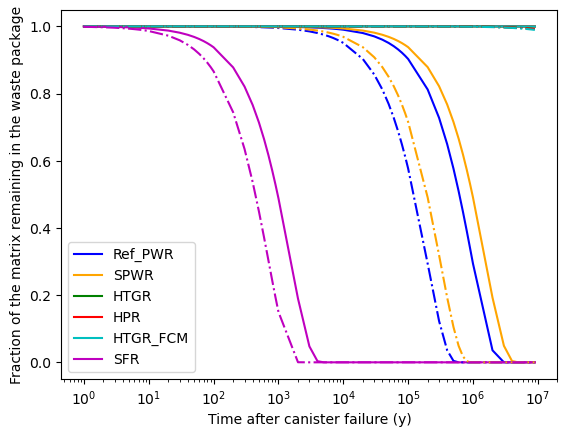

In [55]:
# Plot the fraction of the matrix remaining in the waste package 
fig, ax=plt.subplots()
color=['b', 'orange','g','r','c', 'm', 'y']

f_matrix_low.plot(ax=ax, linestyle='-', color=color)
f_matrix_high.plot(ax=ax, linestyle='-.', color=color)
ax.set_xlabel('Time after canister failure (y)')
ax.set_ylabel('Fraction of the matrix remaining in the waste package')
ax.set_xscale('log')

ax.legend(reactors_legend)

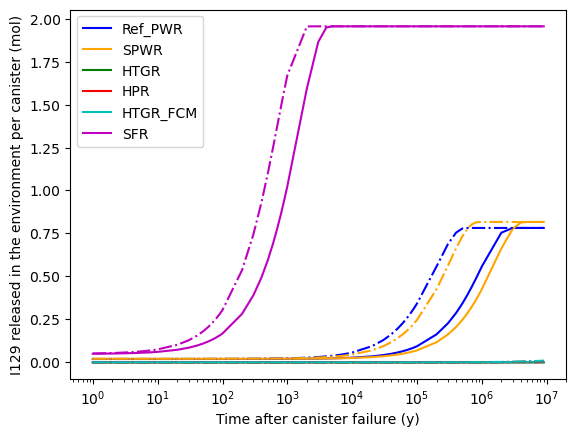

In [56]:
# Plot the quantity of I129 released in the environment per canister in the clay repository, in the low and high conditions
fig, ax=plt.subplots()
color=['b', 'orange','g','r','c', 'm', 'y']

I129_release_can_low.plot(ax=ax, linestyle='-', color=color)
I129_release_can_high.plot(ax=ax, linestyle='-.', color=color)
ax.set_xlabel('Time after canister failure (y)')
ax.set_ylabel('I129 released in the environment per canister (mol)')
ax.set_xscale('log')
ax.legend(reactors_legend)

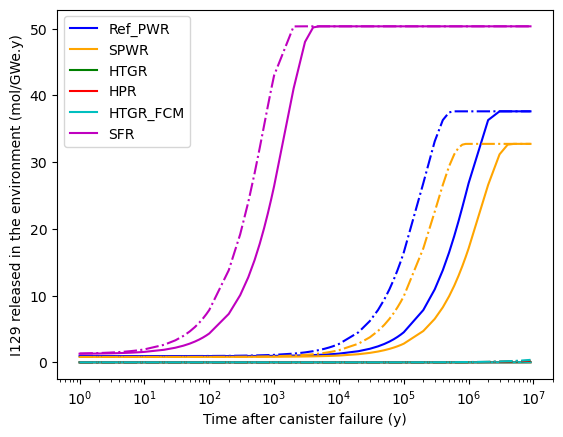

In [57]:
# Plot the I129 mass release for a repository containing the equivalent of 1 GWe.year electricity
fig, ax= plt.subplots()
color=['b', 'orange','g','r','c', 'm', 'y']

I129_release_GWey_low.plot(linestyle='-', color=color, ax=ax)
I129_release_GWey_high.plot(linestyle='-.',color=color, ax=ax)
ax.set_xscale('log')
ax.set_xlabel('Time after canister failure (y)')
ax.set_ylabel('I129 released in the environment (mol/GWe.y)')
ax.legend(reactors_legend)

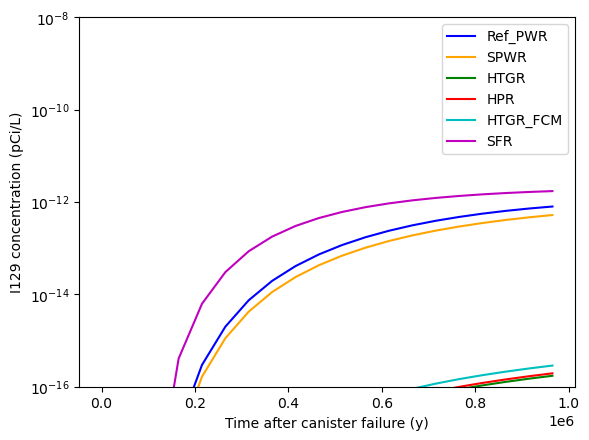

In [58]:
# Plot the I129 concentrations from a repository containing the equivalent of 1 GWe.year electricity
fig, ax= plt.subplots()
color=['b', 'orange','g','r','c', 'm', 'y']

I129_conc.plot(linestyle='-', color=color, ax=ax)
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim((1e-16,1e-8))#
#ax.set_xlim((1e5,1e6))
ax.set_xlabel('Time after canister failure (y)')
ax.set_ylabel('I129 concentration (pCi/L)')
ax.legend(reactors_legend)

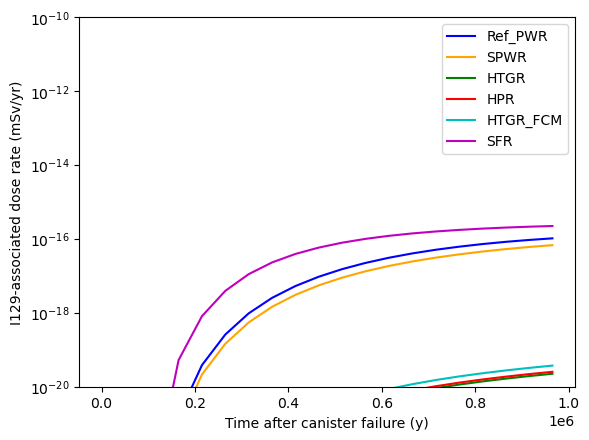

In [59]:
# Plot the I129-associated dose from a repository containing the equivalent of 1 GWe.year electricity
BDCF =1.3e-4 #mSv/yr per pCi/L  https://www.nrc.gov/docs/ML0815/ML081560551.pdf
I129_dose = I129_conc*BDCF

fig, ax= plt.subplots()
color=['b', 'orange','g','r','c', 'm', 'y']

I129_dose.plot(linestyle='-', color=color, ax=ax)
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim((1e-20,1e-10))#
#ax.set_xlim((1e5,1e6))
ax.set_xlabel('Time after canister failure (y)')
ax.set_ylabel('I129-associated dose rate (mSv/yr)')
ax.legend(reactors_legend)

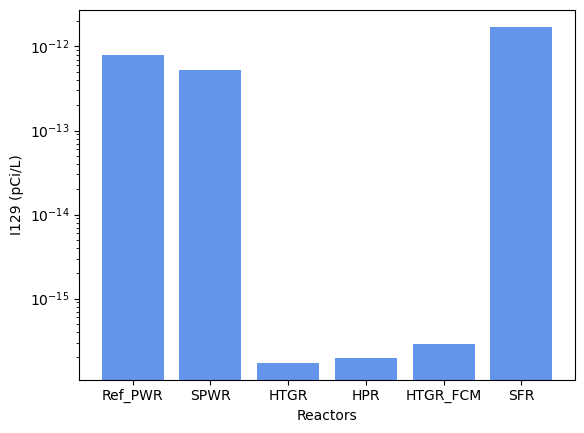

In [60]:
# Peak concentration from a repository containing the equivalent of 1 GWe.year 
plt.bar(x=reactors_legend,height=I129_conc_max.iloc[0,:], color='cornflowerblue')
plt.xlabel('Reactors')
plt.ylabel('I129 (pCi/L)')
plt.yscale('log')

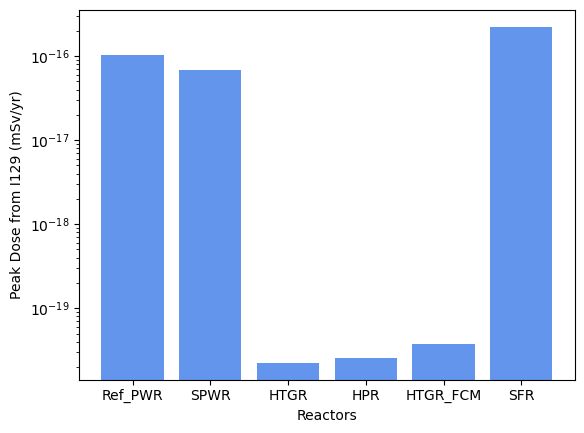

In [61]:
I129_dose_max_GWey=I129_conc_max.multiply(BDCF)
plt.bar(x=reactors_legend,height=I129_dose_max_GWey.iloc[0,:], color='cornflowerblue')
plt.xlabel('Reactors')
plt.ylabel('Peak Dose from I129 (mSv/yr)')
plt.yscale('log')

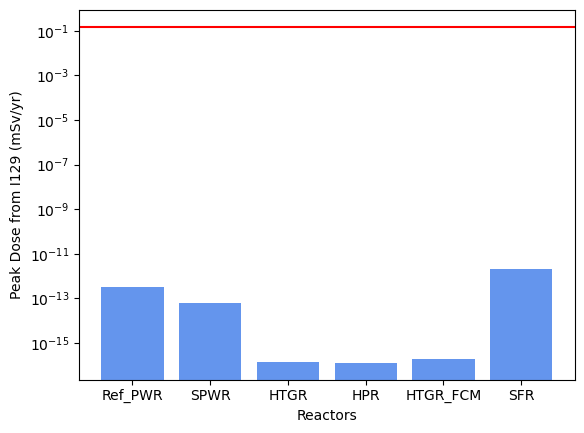

In [62]:
# Peak concentration for YM
guideline = 0.15 # YM criteria mSv/yr

I129_dose_max_rep=I129_dose_max_GWey.multiply(np.array(scaling), axis='columns')

plt.bar(x=reactors_legend,height=I129_dose_max_rep.iloc[0,:], color='cornflowerblue')
plt.axhline(y=guideline, color='r')
plt.xlabel('Reactors')
plt.ylabel('Peak Dose from I129 (mSv/yr)')
plt.yscale('log')